# Midterm 1: Simulating a supersonic fluid flow past a flat plate (shock and boundary layer formation). 

In [1]:
import numpy as np
from scipy import stats
from scipy.interpolate import interp1d
import scipy
import time
import scipy.io
from scipy.sparse import diags
from matplotlib import cm
from matplotlib.ticker import LinearLocator

In [2]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 13}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

# Derivative functions

In [3]:

def ddx_fwd(f, dx, periodic=False):
    # return the first derivative of f in x using a first-order forward difference.
    A = diags([-1, 1], [0, 1], shape=(f.shape[0], f.shape[0])).toarray()
    if periodic:
        A[-1, 0] = 1
    else:
        A[-1, -1] = 1
        A[-1, -2] = -1
    A /= dx
    return A @ f


def ddx_bwd(f, dx, periodic=False):
    # return the first derivative of f in x using a first-order backward difference.
    A = diags([-1, 1], [-1, 0], shape=(f.shape[0], f.shape[0])).toarray()
    if periodic:
        A[0, -1] = -1
        A /= dx
    else:
        A[0, 0] = -1
        A[0, 1] = 1
    A /= dx
    return A @ f

def ddx_central(f, dx, periodic=False):
    # return the first derivative of f in x using a first-order central difference.
    A = diags([-1, 1], [-1, 1], shape=(f.shape[0], f.shape[0])).toarray()
    if periodic:
        A[0, -1] = -1
        A[-1, 0] = 1
    else:
        A[0, 0] = -3
        A[0, 1] = 4
        A[0, 2] = -1
        A[-1, -1] = 3
        A[-1, -2] = -4
        A[-1, -3] = 1
    A /= (2 * dx)
    return A @ f

# Conservative Form Conversion 

In [4]:
def prim2cons(rho, u, v, T, cv=718):
    return np.array([rho, rho * u, rho * v, rho * (cv * T + 0.5 * (u ** 2 + v ** 2))])


def cons2prim(U, R=287, cv=718):
    rho = U[0]
    u = U[1] / rho
    v = U[2] / rho
    Et = U[3]
    e = Et / rho - 0.5 * (u ** 2 + v ** 2)
    T = e / cv
    p = rho * R * T
    return np.array([rho, u, v, T, p, e, Et])

# Compressible Flow Function

In [5]:
def sutherland(T, mu0=1.735 * 1e-5, Temp0=288.15, Stemp1=110):
    T_pow = (T / Temp0) ** 3
    T_pow = np.sqrt(T_pow)
    return mu0 * T_pow * ((Temp0 + Stemp1) / (T + Stemp1))


def density_perfect_gas(p, T, R=287):
    return p / (R * T)


def internal_energy(T, cv=718):
    return cv * T


def heat_capacity_ratio(mu, cp=1005, pr=0.71):
    return (cp / pr) * mu

# Stress Tensor Components

In [6]:
def tau_xx_fun(dudx, dvdy, mu):
    return 2 * mu * (dudx - 1 / 3 * (dudx + dvdy))


def tau_yy_fun(dvdy, dudx, mu):
    return 2 * mu * (dvdy - 1 / 3 * (dudx + dvdy))


def tau_xy_fun(dudy, dvdx, mu):
    return mu * (dudy + dvdx)

# Heat Gradient Components 

In [7]:
def qx_fun(dTdx, mu):
    k = heat_capacity_ratio(mu)
    return -k * dTdx


def qy_fun(dTdy, mu):
    k = heat_capacity_ratio(mu)
    return -k * dTdy

# Spatial Domain

In [8]:
# spatial domain
L = 1e-5
H = 8 * 1e-6

In [9]:
x = np.linspace(0, L, 75)
y = np.linspace(0, H, 80)
dx = x[1] - x[0]
dy = y[1] - y[0]
# time step (CFL)
dx = x[1] - x[0]
dy = y[1] - y[0]
dt = 2.35*1e-11

# Flow Properties

In [10]:
# mach number 1< m < 5 (supersonic)
Minf = 4
# molar gas constant
R = 287  # J/kgK
# isobaric specific heat (cp)
cp = 1005  # J/kgK
# isochronic specific heat (cv)
cv = 718  # J/kgK
# prandtl number
pr = 0.71

# Boundary conditions

In [11]:
def boundary_conditions(U, Tinf, pinf, uinf):
    rho, u, v, T, p, e, Et = cons2prim(U=U)
    # @ the wall
    u[:, 0] = np.zeros(u.shape[0])
    v[:, 0] = np.zeros(v.shape[0])
    T[:, 0] = np.ones(T.shape[0]) * Tinf
    p[:, 0] = 2 * p[:, 1] - p[:, 2]
    # @ the inlet
    u[0, 1:] = np.ones(u.shape[1] - 1) * uinf
    v[0, 1:] = np.zeros(v.shape[1] - 1)
    p[0, 1:] = np.ones(p.shape[1] - 1) * pinf
    T[0, 1:] = np.ones(T.shape[1] - 1) * Tinf
    # @ the far field
    u[:, -1] = np.ones(u.shape[0]) * uinf
    v[:, -1] = np.zeros(v.shape[0])
    p[:, -1] = np.ones(p.shape[0]) * pinf
    T[:, -1] = np.ones(T.shape[0]) * Tinf
    # @ the outflow
    u[-1, 1:-1] = 2 * u[-2, 1:-1] - u[-3, 1:-1]
    v[-1, 1:-1] = 2 * v[-2, 1:-1] - v[-3, 1:-1]
    p[-1, 1:-1] = 2 * p[-2, 1:-1] - p[-3, 1:-1]
    T[-1, 1:-1] = 2 * T[-2, 1:-1] - T[-3, 1:-1]
    # @ corners
    # wall and inlet - trailing edge
    u[0, 0] = 0
    v[0, 0] = 0
    p[0, 0] = pinf
    T[0, 0] = Tinf

    rho = density_perfect_gas(p=p, T=T)
    return cons2prim(U=prim2cons(rho=rho, u=u, v=v, T=T))

# MacCormack Method

In [12]:

def supersonic_compressible_maccormack(U, dx, dy, dt, Tinf, uinf, pinf):
    # primitive quantities
    rho, u, v, T, p, e, Et = cons2prim(U=U)

    # density using sutherland's law
    mu = sutherland(T=T)

    # predictor step
    # E vector
    # tau_xx
    dudx = ddx_bwd(u, dx)
    dvdy = ddx_central(v.T, dy).T
    tau_xx = tau_xx_fun(dudx=dudx, dvdy=dvdy, mu=mu)
    # tau_xy
    dudy = ddx_central(u.T, dy).T
    dvdx = ddx_bwd(v, dx)
    tau_xy_E = tau_xy_fun(dudy=dudy, dvdx=dvdx, mu=mu)
    # qx
    dTdx = ddx_bwd(T, dx)
    q_x = qx_fun(dTdx=dTdx, mu=mu)

    E = np.array([rho * u,
                  rho * u * u + p - tau_xx,
                  rho * v * u - tau_xy_E,
                  (Et + p) * u - u * tau_xx - v * tau_xy_E + q_x])

    dEdx = np.zeros(E.shape)
    dEdx[0] = ddx_fwd(E[0], dx)
    dEdx[1] = ddx_fwd(E[1], dx)
    dEdx[2] = ddx_fwd(E[2], dx)
    dEdx[3] = ddx_fwd(E[3], dx)

    # F vector
    # tau_yy
    dvdy = ddx_bwd(v.T, dy).T
    dudx = ddx_central(u, dx)
    tau_yy = tau_yy_fun(dvdy=dvdy, dudx=dudx, mu=mu)
    # tau_xy
    dudy = ddx_bwd(u.T, dy).T
    dvdx = ddx_central(v, dx)
    tau_xy_F = tau_xy_fun(dudy=dudy, dvdx=dvdx, mu=mu)
    # qy
    dTdy = ddx_bwd(T.T, dy).T
    q_y = qy_fun(dTdy=dTdy, mu=mu)

    F = np.array([rho * v,
                  rho * u * v - tau_xy_F,
                  rho * v * v + p - tau_yy,
                  (Et + p) * v - v * tau_yy - u * tau_xy_F + q_y])

    dFdy = np.zeros(F.shape)
    dFdy[0] = ddx_fwd(F[0].T, dy).T
    dFdy[1] = ddx_fwd(F[1].T, dy).T
    dFdy[2] = ddx_fwd(F[2].T, dy).T
    dFdy[3] = ddx_fwd(F[3].T, dy).T

    # predictor step
    U_pred = U - dt * dEdx - dt * dFdy

    # enforce boundary conditions
    # primitive quantities
    rho, u, v, T, p, e, Et = boundary_conditions(U=U_pred, Tinf=Tinf, uinf=uinf, pinf=pinf)

    # corrector step
    # density using sutherland's law
    mu = sutherland(T=T)

    # ****corrector step*****
    # E vector
    # tau_xx
    dudx = ddx_fwd(u, dx)
    dvdy = ddx_central(v.T, dy).T
    tau_xx = tau_xx_fun(dudx=dudx, dvdy=dvdy, mu=mu)
    # tau_xy
    dudy = ddx_central(u.T, dy).T
    dvdx = ddx_fwd(v, dx)
    tau_xy_E = tau_xy_fun(dudy=dudy, dvdx=dvdx, mu=mu)
    # qx
    dTdx = ddx_fwd(T, dx)
    q_x = qx_fun(dTdx=dTdx, mu=mu)

    E = np.array([rho * u,
                  rho * u * u + p - tau_xx,
                  rho * v * u - tau_xy_E,
                  (Et + p) * u - u * tau_xx - v * tau_xy_E + q_x])

    dEdx = np.zeros(E.shape)
    dEdx[0] = ddx_bwd(E[0], dx)
    dEdx[1] = ddx_bwd(E[1], dx)
    dEdx[2] = ddx_bwd(E[2], dx)
    dEdx[3] = ddx_bwd(E[3], dx)

    # F vector
    # tau_yy
    dvdy = ddx_fwd(v.T, dy).T
    dudx = ddx_central(u, dx)
    tau_yy = tau_yy_fun(dvdy=dvdy, dudx=dudx, mu=mu)
    # tau_xy
    dudy = ddx_fwd(u.T, dy).T
    dvdx = ddx_central(v, dx)
    tau_xy_F = tau_xy_fun(dudy=dudy, dvdx=dvdx, mu=mu)
    # qy
    dTdy= ddx_fwd(T.T, dy).T
    q_y = qy_fun(dTdy=dTdy, mu=mu)

    F = np.array([rho * v,
                  rho * u * v - tau_xy_F,
                  rho * v * v + p - tau_yy,
                  (Et + p) * v - v * tau_yy - u * tau_xy_F + q_y])

    dFdy = np.zeros(F.shape)
    dFdy[0] = ddx_bwd(F[0].T, dy).T
    dFdy[1] = ddx_bwd(F[1].T, dy).T
    dFdy[2] = ddx_bwd(F[2].T, dy).T
    dFdy[3] = ddx_bwd(F[3].T, dy).T

    # corrector step
    U_next = 0.5 * (U_pred + U - dt * dEdx - dt * dFdy)

    rho, u, v, T, p, e, Et = boundary_conditions(U=U_next, Tinf=Tinf, uinf=uinf, pinf=pinf)
    return prim2cons(rho=rho, u=u, v=v, T=T)

# Initial Condition

In [14]:
speed_of_light_in_air = 340.28  # m/s
pressure_in_air = 101300.  # N/m^2
temp_in_air = 288.15  # Kelvin

u0 = np.ones((len(x), len(y))) * speed_of_light_in_air * Minf
u0[:, 0] = np.zeros(len(x))  # slip boundary condition
v0 = np.zeros((len(x), len(y)))
p0 = np.ones((len(x), len(y))) * pressure_in_air
T0 = np.ones((len(x), len(y))) * temp_in_air
rho0 = density_perfect_gas(p=p0, T=T0)
U0 = prim2cons(rho=rho0, u=u0, v=v0, T=T0)
mu = sutherland(T0)

# Run MacCormack

In [32]:
nt = 1501 # number of time step.
t = np.linspace(0, dt * nt, int(nt))
U_sol = np.zeros((4, len(x), len(y), len(t)))
U_sol[:, :, :, 0] = U0
X, Y = np.meshgrid(x, y)

for ii in range(0, int(nt) - 1):
    U_sol[:, :, :, ii + 1] = supersonic_compressible_maccormack(U=U_sol[:, :, :, ii],
                                                                dx=dx,
                                                                dy=dy,
                                                                dt=dt,
                                                                uinf=speed_of_light_in_air * Minf,
                                                                pinf=pressure_in_air,
                                                                Tinf=temp_in_air)
    #fig, ax = plt.subplots()
    #pos = ax.pcolormesh(X, Y, U_sol[1, :, :, ii].T/U_sol[0, :, :, ii].T, shading='gouraud')
    #ax.set_title("t = " + str(t[ii]))
    #fig.colorbar(pos, ax=ax)
    #plt.savefig("supersonic_flow/" + str(ii) + ".png", dpi=100)
    #plt.close()

In [33]:
ii

1499

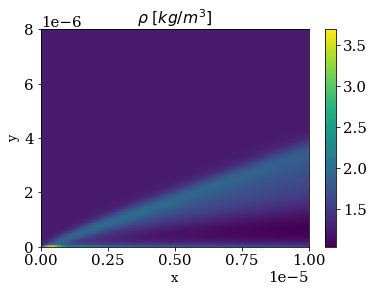

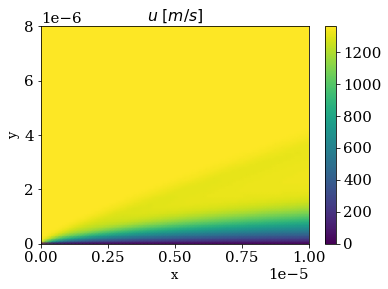

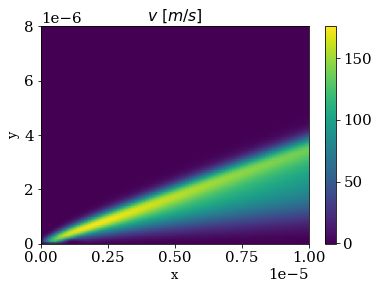

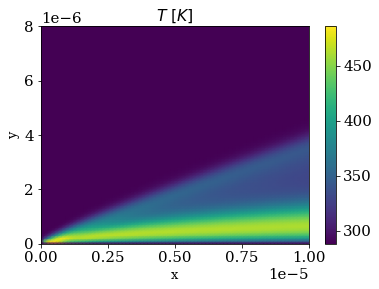

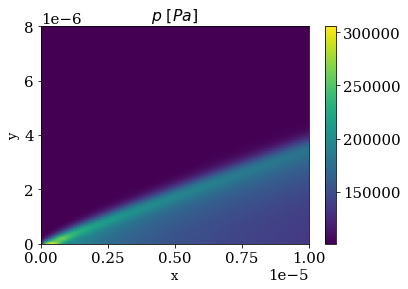

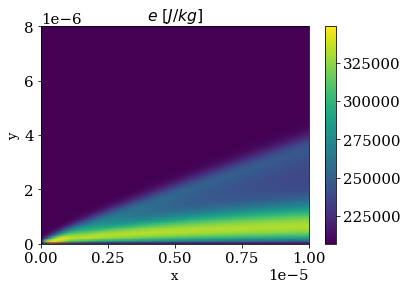

In [34]:
rho, u, v, T, p, e, Et = boundary_conditions(U=U_sol[:, :, :, ii],
                                             Tinf=temp_in_air,
                                             uinf=speed_of_light_in_air*Minf,
                                             pinf=pressure_in_air)
fig, ax = plt.subplots()
pos = ax.pcolormesh(X, Y, rho.T, shading='gouraud')
ax.set_title(r"$\rho$"+  " " + "$[kg/m^3]$")
fig.colorbar(pos, ax=ax)
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.savefig("supersonic_flow/rho_" + str(ii) + ".png", dpi=100)

fig, ax = plt.subplots()
pos = ax.pcolormesh(X, Y, u.T, shading='gouraud')
ax.set_title(r"$u$"+  " " + "$[m/s]$")
fig.colorbar(pos, ax=ax)
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.savefig("supersonic_flow/u_" + str(ii) + ".png", dpi=100)

fig, ax = plt.subplots()
pos = ax.pcolormesh(X, Y, v.T, shading='gouraud')
ax.set_title(r"$v$"+  " " + "$[m/s]$")
fig.colorbar(pos, ax=ax)
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.savefig("supersonic_flow/v_" + str(ii) + ".png", dpi=100)

fig, ax = plt.subplots()
pos = ax.pcolormesh(X, Y, T.T, shading='gouraud')
ax.set_title(r"$T$"+  " " + "$[K]$")
fig.colorbar(pos, ax=ax)
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.savefig("supersonic_flow/T_" + str(ii) + ".png", dpi=100)

fig, ax = plt.subplots()
pos = ax.pcolormesh(X, Y, p.T, shading='gouraud')
ax.set_title(r"$p$"+  " " + "$[Pa]$")
fig.colorbar(pos, ax=ax)
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.savefig("supersonic_flow/p_" + str(ii) + ".png", dpi=100)

fig, ax = plt.subplots()
pos = ax.pcolormesh(X, Y, e.T, shading='gouraud')
ax.set_title(r"$e$"+  " " + "$[J/kg]$")
ax.set_xlabel("x")
ax.set_ylabel("y")
fig.colorbar(pos, ax=ax)
plt.savefig("supersonic_flow/e_" + str(ii) + ".png", dpi=100)